Number of null values in each column track_id                    0
track_name                  5
track_artist                5
track_popularity            0
track_album_id              0
track_album_name            5
track_album_release_date    0
playlist_name               0
playlist_id                 0
playlist_genre              0
playlist_subgenre           0
danceability                0
energy                      0
key                         0
loudness                    0
mode                        0
speechiness                 0
acousticness                0
instrumentalness            0
liveness                    0
valence                     0
tempo                       0
duration_ms                 0
dtype: int64
Number of duplicated values in each column:  0


,track_artist,track_name,track_album_name
0,Ed Sheeran,I Don't Care (with Justin Bieber) - Loud Luxur...,I Don't Care (with Justin Bieber) [Loud Luxury...
1,Maroon 5,Memories - Dillon Francis Remix,Memories (Dillon Francis Remix)
2,Zara Larsson,All the Time - Don Diablo Remix,All the Time (Don Diablo Remix)
3,The Chainsmokers,Call You Mine - Keanu Silva Remix,Call You Mine - The Remixes
4,Lewis Capaldi,Someone You Loved - Future Humans Remix,Someone You Loved (Future Humans Remix)
...,...,...,...
32828,Lush & Simon,City Of Lights - Official Radio Edit,City Of Lights (Vocal Mix)
32829,Tegan and Sara,Closer - Sultan & Ned Shepard Remix,Closer Remixed
32830,Starkillers,Sweet Surrender - Radio Edit,Sweet Surrender (Radio Edit)
32831,Mat Zo,Only For You - Maor Levi Remix,Only For You (Remixes)


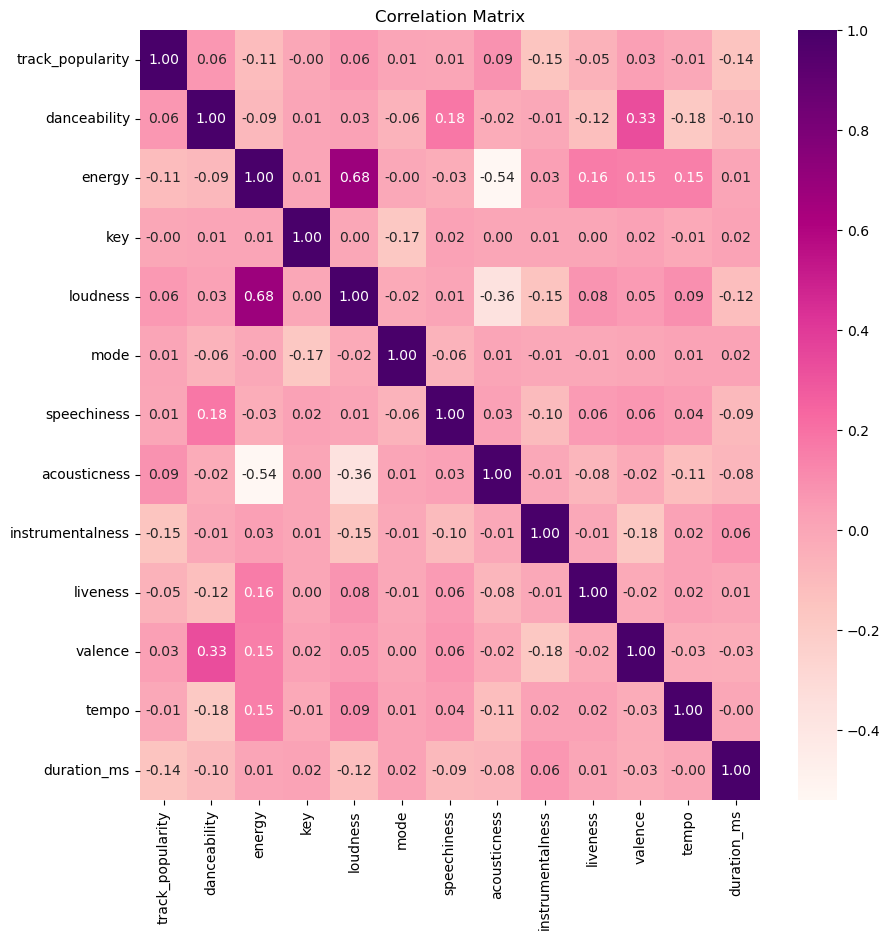

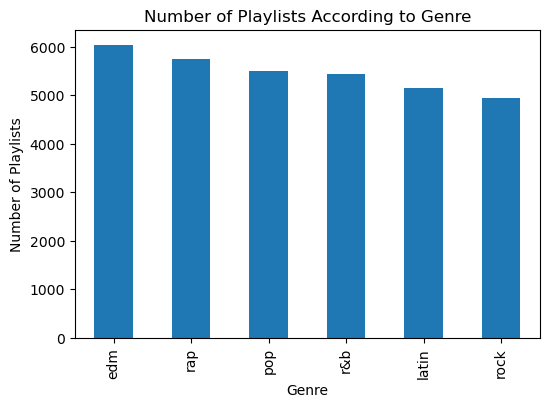

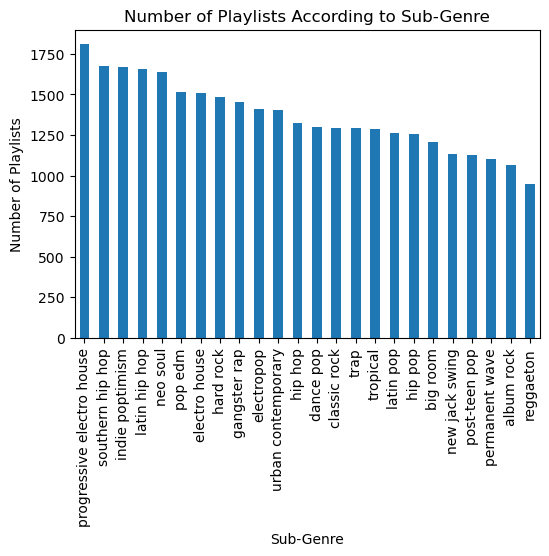

In [1]:
#load dataset, fix null/duplicated values and remove useless cat cols and save important cat cols. 

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
spotify_df_full = pd.read_csv('data/spotify_songs.csv')

#check num of null values in each feature
print("Number of null values in each column", spotify_df_full.isnull().sum())

#check num of duplicated values in each feature
print("Number of duplicated values in each column: ", spotify_df_full.duplicated().sum())

#drop duplicates & drop null values
spotify_df = spotify_df_full.drop_duplicates().dropna()


#drop categorical values that aren't going to be used
spotify_df = spotify_df.drop(columns=["track_id" , "track_album_id", "track_album_release_date", "playlist_id"])

#save important categorical information in a different df
recommendation_info = spotify_df[['track_artist', 'track_name', 'track_album_name']]
display(recommendation_info)


#see if any values are highly correlated > 0.75 because to prevent inflation of feature importance. 
numerical_cols = spotify_df.select_dtypes(include=['float64', 'int64']).columns
correlation_matrix = spotify_df[numerical_cols].corr()

plt.figure(figsize=(10,10))
sns.heatmap(correlation_matrix, annot=True, cmap="RdPu", fmt=".2f")
plt.title("Correlation Matrix")
plt.show()


plt.figure(figsize=(6,4))
playlist_genre = spotify_df['playlist_genre'].value_counts().plot(kind='bar')
plt.ylabel("Number of Playlists")
plt.xlabel("Genre")
plt.title("Number of Playlists According to Genre")


plt.figure(figsize=(6,4))
subgr = spotify_df['playlist_subgenre'].value_counts().plot(kind='bar')
plt.ylabel("Number of Playlists")
plt.xlabel("Sub-Genre")
plt.title("Number of Playlists According to Sub-Genre")

spotify_df = spotify_df.drop(columns=['track_artist', 'track_name', 'track_album_name'])


In [2]:
#features with many outliers: sppechniqess, acousticness, instrumentallness
#features with some outliers: loudness, liveness, duration_ms
#loudness is negative values. 

#fixing outliers

#select numerical cols from the dataset. 
numerical_cols = spotify_df.select_dtypes(include=['float64', 'int64']).columns



#empty dict to keep track of how many outliers per col. features with many outliers can skew data. need to fix if they skew data. 
out_sum = {}

for col in numerical_cols:
    Q1 = spotify_df[col].quantile(0.25)
    Q3 = spotify_df[col].quantile(0.75)
    IQR = Q3-Q1

    lower_bound = Q1- 1.5*IQR
    upper_bound = Q3 + 1.5*IQR

    #check num lower/upper outliers and add to dict. 
    outlier = ((spotify_df[col] < lower_bound) | (spotify_df[col] > upper_bound)).sum()
    out_sum[col] = outlier

display(out_sum)


{'track_popularity': np.int64(0),
 'danceability': np.int64(291),
 'energy': np.int64(277),
 'key': np.int64(0),
 'loudness': np.int64(1021),
 'mode': np.int64(0),
 'speechiness': np.int64(3174),
 'acousticness': np.int64(2205),
 'instrumentalness': np.int64(7030),
 'liveness': np.int64(1842),
 'valence': np.int64(0),
 'tempo': np.int64(571),
 'duration_ms': np.int64(1387)}

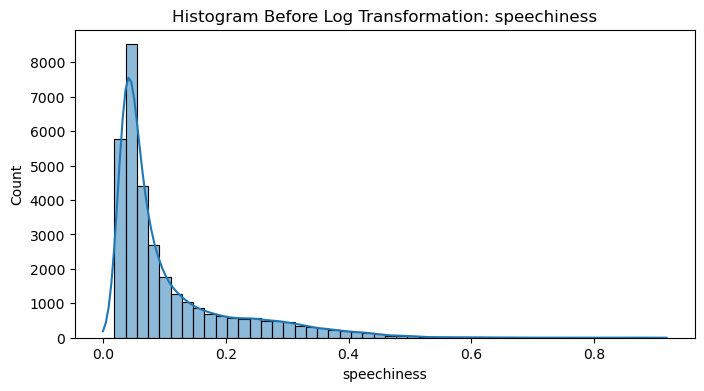

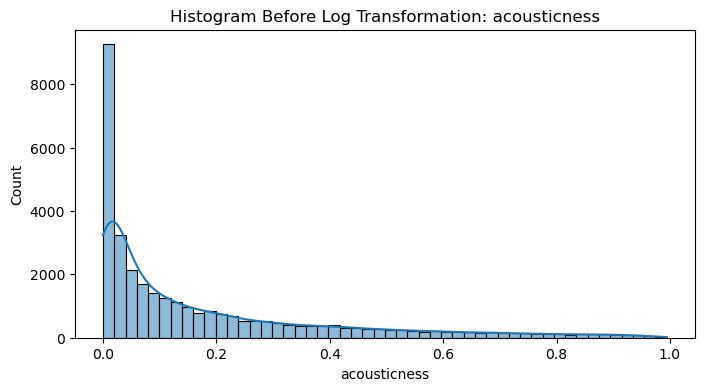

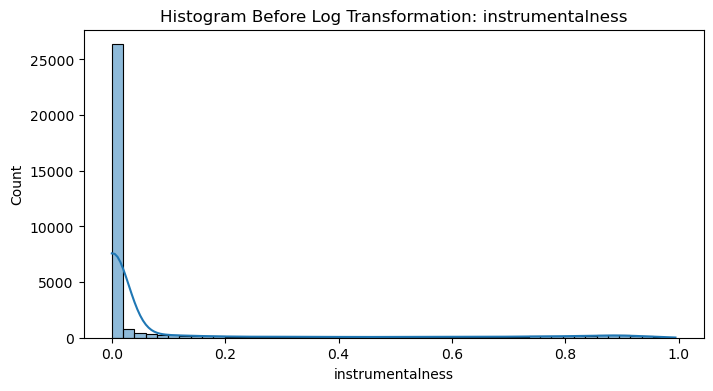

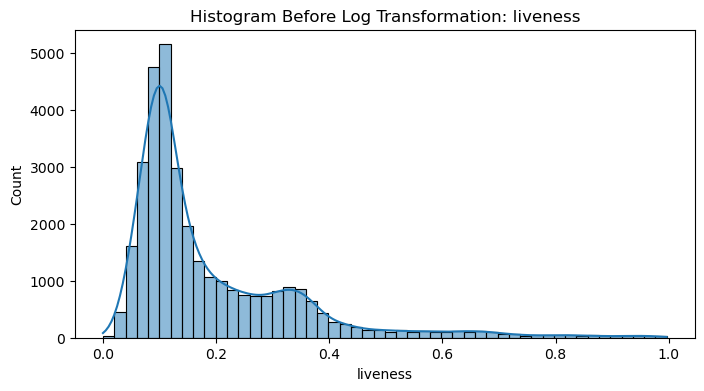

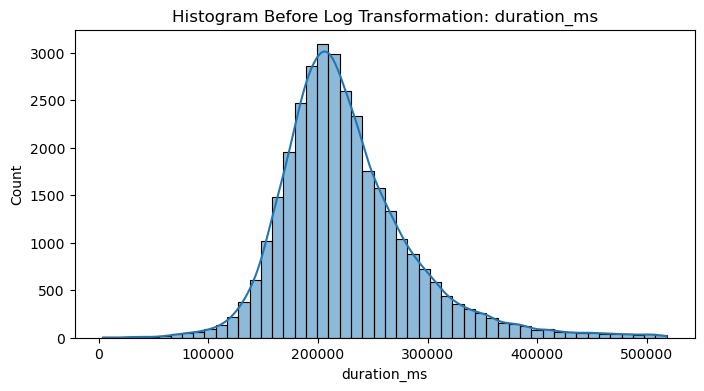

In [3]:
most_outliers = ['speechiness', 'acousticness', 'instrumentalness', 'liveness', 'duration_ms']


for col in most_outliers:
    plt.figure(figsize=(8,4))
    sns.histplot(spotify_df[col], kde=True, bins=50)
    plt.title(f"Histogram Before Log Transformation: {col}")
    plt.xlabel(col)
    plt.ylabel("Count")
    plt.show()

    

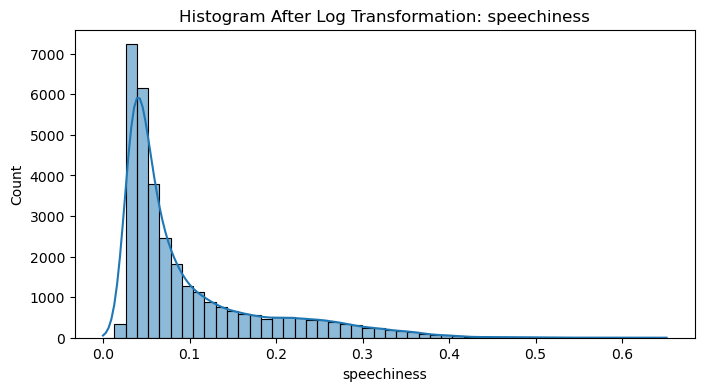

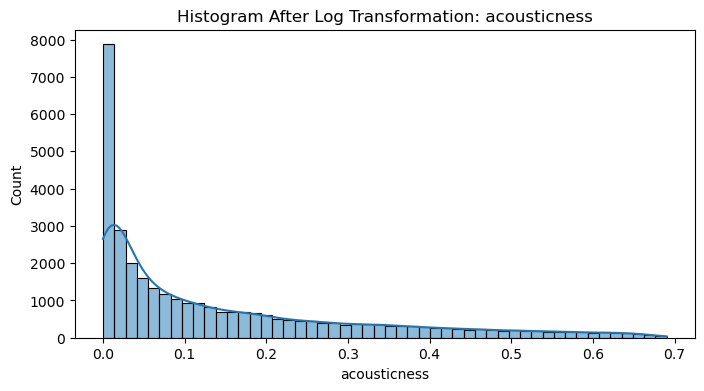

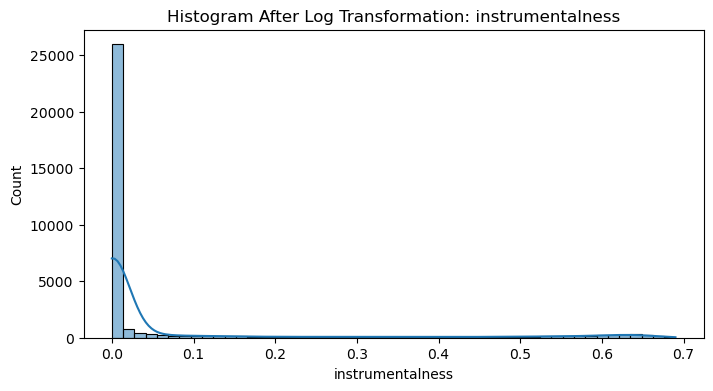

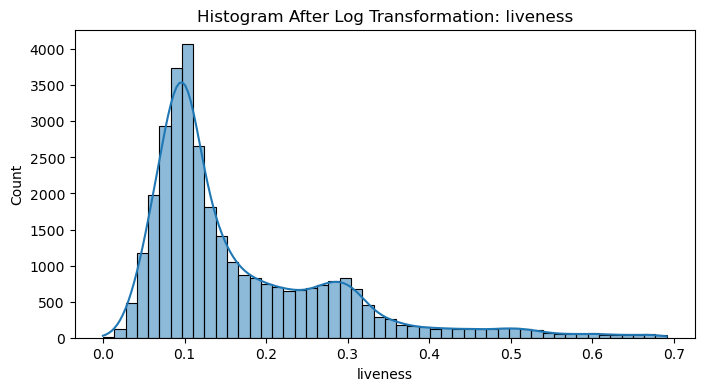

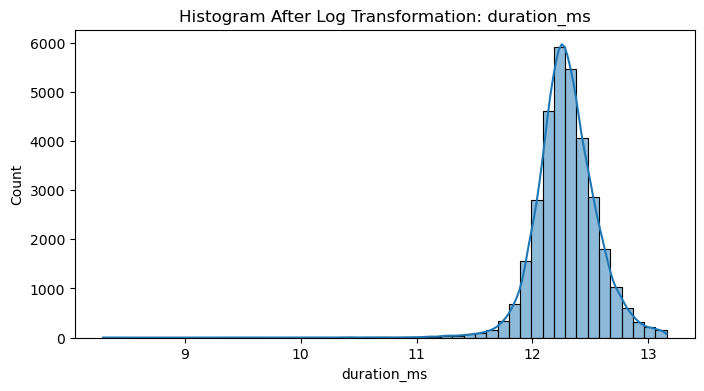

In [4]:
#log transform skewed values reduce influence of extremely large values
import numpy as np
skewed = ['speechiness', 'acousticness', 'instrumentalness', 'liveness', 'duration_ms']

for col in skewed: 
    spotify_df[col] = np.log1p(spotify_df[col])
    plt.figure(figsize=(8,4))
    sns.histplot(spotify_df[col], kde=True, bins=50)
    plt.title(f"Histogram After Log Transformation: {col}")
    plt.xlabel(col)
    plt.ylabel("Count")
    plt.show()



In [5]:
#frequency encoding for name and playlist subgenre; good for features with high cardinality. 

freq_cols = ['playlist_name', 'playlist_subgenre']

for col in freq_cols:
    freq = spotify_df[col].value_counts(normalize=True)
    spotify_df[col] = spotify_df[col].map(freq)

In [6]:
from sklearn.preprocessing import OneHotEncoder
#can be used for genre because there's only 6 diff genres. 
labelgenre_encoder = OneHotEncoder(sparse_output = False)

genre = labelgenre_encoder.fit_transform(spotify_df[['playlist_genre']])

genre_df = pd.DataFrame(genre, columns = labelgenre_encoder.get_feature_names_out(['playlist_genre']), index=spotify_df.index)
spotify_df= spotify_df.drop(columns=['playlist_genre'])
spotify_df = pd.concat([spotify_df, genre_df], axis=1)

display(spotify_df)

,track_popularity,playlist_name,playlist_subgenre,danceability,energy,key,loudness,mode,speechiness,acousticness,...,liveness,valence,tempo,duration_ms,playlist_genre_edm,playlist_genre_latin,playlist_genre_pop,playlist_genre_r&b,playlist_genre_rap,playlist_genre_rock
0,66,0.002132,0.039539,0.748,0.916,6,-2.634,1,0.056664,0.097127,...,0.063256,0.5180,122.036,12.179498,0.0,0.0,1.0,0.0,0.0,0.0
1,67,0.002132,0.039539,0.726,0.815,11,-4.969,1,0.036621,0.069899,...,0.305276,0.6930,99.972,11.999055,0.0,0.0,1.0,0.0,0.0,0.0
2,70,0.002132,0.039539,0.675,0.931,1,-3.432,0,0.071576,0.076405,...,0.104360,0.6130,124.008,12.081739,0.0,0.0,1.0,0.0,0.0,0.0
3,60,0.002132,0.039539,0.718,0.930,7,-3.778,1,0.097127,0.028296,...,0.185649,0.2770,121.956,12.038210,0.0,0.0,1.0,0.0,0.0,0.0
4,69,0.002132,0.039539,0.650,0.833,1,-4.672,1,0.035271,0.077239,...,0.080012,0.7250,123.976,12.149783,0.0,0.0,1.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32828,42,0.002437,0.055105,0.428,0.922,2,-1.814,1,0.089475,0.073808,...,0.064664,0.2100,128.170,12.227717,1.0,0.0,0.0,0.0,0.0,0.0
32829,20,0.002437,0.055105,0.522,0.786,0,-4.462,1,0.041142,0.001709,...,0.318454,0.4000,128.041,12.774566,1.0,0.0,0.0,0.0,0.0,0.0
32830,14,0.002437,0.055105,0.529,0.821,6,-4.899,0,0.046979,0.102557,...,0.139762,0.4360,127.989,12.255401,1.0,0.0,0.0,0.0,0.0,0.0
32831,15,0.002437,0.055105,0.626,0.888,2,-3.361,1,0.103459,0.007889,...,0.294906,0.3080,128.008,12.814296,1.0,0.0,0.0,0.0,0.0,0.0


In [7]:
#scale numerical values b/c KNN needs scaling for the euclidean distance and for gradient descent NN. 
from sklearn.preprocessing import StandardScaler
numerical_cols = spotify_df.select_dtypes(include=['float64', 'int64']).columns
scaler = StandardScaler()
spotify_df[numerical_cols] = scaler.fit_transform(spotify_df[numerical_cols])

